In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, recall_score
import matplotlib.pyplot as plt
import time

In [21]:
# Memuat dan mempersiapkan dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


In [22]:
# Normalisasi data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [23]:
# One-hot encoding untuk labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [24]:
# Callbacks untuk training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
]

In [25]:
# Fungsi untuk membuat model MLP
def create_mlp():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [26]:
# Fungsi untuk membuat model CNN
def create_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [27]:
# Fungsi untuk evaluasi model dan menghitung metrik
def evaluate_model(model, model_name, X_train, y_train_cat, X_test, y_test_cat, y_test):
    print(f"\n===== Evaluasi Model {model_name} =====")
    
    # Prediksi
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Train accuracy
    train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
    
    # Test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    
    # Presisi (weighted untuk dataset multiclass)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Recall (weighted untuk dataset multiclass)
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # F1 score (weighted untuk dataset multiclass)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ROC AUC (one-vs-rest approach untuk multiclass)
    roc_auc = roc_auc_score(y_test_cat, y_pred_prob, multi_class='ovr')
    
    print(f"Model: {model_name}")
    print(f"Akurasi Training: {train_acc*100:.2f}%")
    print(f"Akurasi Testing: {test_acc*100:.2f}%")
    print(f"Presisi: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    # Disimpan dalam dictionary untuk perbandingan nanti
    return {
        'model': model_name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': roc_auc,
        'pred_probs': y_pred_prob,
        'y_pred': y_pred
    }


In [28]:
# Training and evaluating MLP
print("===== Training Model MLP =====")
mlp_model = create_mlp()
mlp_model.summary()

start_time = time.time()
mlp_history = mlp_model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
mlp_train_time = time.time() - start_time


===== Training Model MLP =====


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,812,618 (14.54 MB)

 Trainable params: 3,809,034 (14.53 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.2200 - loss: 2.6129 - val_accuracy: 0.3348 - val_loss: 1.8842 - learning_rate: 0.0010
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3279 - loss: 1.8940 - val_accuracy: 0.3680 - val_loss: 1.7616 - learning_rate: 0.0010
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3763 - loss: 1.7471 - val_accuracy: 0.3478 - val_loss: 1.8675 - learning_rate: 0.0010
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3838 - loss: 1.7143 - val_accuracy: 0.4082 - val_loss: 1.6666 - learning_rate: 0.0010
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.4032 - loss: 1.6769 - val_accuracy: 0.4210 - val_loss: 1.6179 - learning_rate: 0.0010
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.3928 - loss: 1.6861 - val_accuracy: 0.4028 - val_loss: 1.6674 - learning_rate: 0.0010
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.3963 - l

In [29]:
# Training and evaluating CNN
print("\n===== Training Model CNN =====")
cnn_model = create_cnn()
cnn_model.summary()

start_time = time.time()
cnn_history = cnn_model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
cnn_train_time = time.time() - start_time


===== Training Model CNN =====


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 109s 291ms/step - accuracy: 0.3513 - loss: 2.1576 - val_accuracy: 0.1194 - val_loss: 3.7682 - learning_rate: 0.0010
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 101s 288ms/step - accuracy: 0.5728 - loss: 1.2388 - val_accuracy: 0.6224 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 100s 285ms/step - accuracy: 0.6684 - loss: 0.9412 - val_accuracy: 0.6978 - val_loss: 0.8873 - learning_rate: 0.0010
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 100s 285ms/step - accuracy: 0.7160 - loss: 0.7990 - val_accuracy: 0.7372 - val_loss: 0.7588 - learning_rate: 0.0010
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 103s 292ms/step - accuracy: 0.7502 - loss: 0.7088 - val_accuracy: 0.7606 - val_loss: 0.7041 - learning_rate: 0.0010
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 103s 294ms/step - accuracy: 0.7774 - loss: 0.6291 - val_accuracy: 0.7672 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accura

In [30]:
# Evaluasi model
mlp_results = evaluate_model(mlp_model, "MLP", X_train, y_train_cat, X_test, y_test_cat, y_test)
cnn_results = evaluate_model(cnn_model, "CNN", X_train, y_train_cat, X_test, y_test_cat, y_test)



===== Evaluasi Model MLP =====
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: MLP
Akurasi Training: 48.37%
Akurasi Testing: 46.86%
Presisi: 0.4713
Recall: 0.4686
F1 Score: 0.4602
AUC-ROC: 0.8722

===== Evaluasi Model CNN =====
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Model: CNN
Akurasi Training: 95.79%
Akurasi Testing: 83.95%
Presisi: 0.8389
Recall: 0.8395
F1 Score: 0.8384
AUC-ROC: 0.9854


In [31]:
# Visualisasi hasil perbandingan
def plot_training_history(mlp_history, cnn_history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(mlp_history.history['accuracy'], label='MLP training')
    plt.plot(mlp_history.history['val_accuracy'], label='MLP validation')
    plt.plot(cnn_history.history['accuracy'], label='CNN training')
    plt.plot(cnn_history.history['val_accuracy'], label='CNN validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(mlp_history.history['loss'], label='MLP training')
    plt.plot(mlp_history.history['val_loss'], label='MLP validation')
    plt.plot(cnn_history.history['loss'], label='CNN training')
    plt.plot(cnn_history.history['val_loss'], label='CNN validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [32]:
def plot_metrics_comparison():
    metrics = ['train_acc', 'test_acc', 'precision', 'recall', 'f1', 'auc_roc']
    labels = ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
    
    mlp_values = [mlp_results[metric] for metric in metrics]
    cnn_values = [cnn_results[metric] for metric in metrics]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 6))
    rects1 = ax.bar(x - width/2, mlp_values, width, label='MLP')
    rects2 = ax.bar(x + width/2, cnn_values, width, label='CNN')
    
    ax.set_ylabel('Scores')
    ax.set_title('Performance Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    # Add values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()


In [33]:
def plot_roc_curves():
    plt.figure(figsize=(10, 8))
    
    # Kita ambil kelas pertama (0) untuk contoh visualisasi
    for class_id in range(10):
        # ROC curve untuk MLP
        fpr_mlp, tpr_mlp, _ = roc_curve(y_test_cat[:, class_id], mlp_results['pred_probs'][:, class_id])
        plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Class {class_id} (AUC = {roc_auc_score(y_test_cat[:, class_id], mlp_results["pred_probs"][:, class_id]):.3f})')
        
        # ROC curve untuk CNN
        fpr_cnn, tpr_cnn, _ = roc_curve(y_test_cat[:, class_id], cnn_results['pred_probs'][:, class_id])
        plt.plot(fpr_cnn, tpr_cnn, label=f'CNN Class {class_id} (AUC = {roc_auc_score(y_test_cat[:, class_id], cnn_results["pred_probs"][:, class_id]):.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend(loc='lower right')
    plt.show()


In [34]:
# Fungsi untuk plot confusion matrix
def plot_confusion_matrices():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # MLP Confusion Matrix
    cm_mlp = confusion_matrix(y_test, mlp_results['y_pred'])
    im1 = ax1.imshow(cm_mlp, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title('Confusion Matrix - MLP')
    fig.colorbar(im1, ax=ax1)
    
    # Add class labels
    classes = [f'Class {i}' for i in range(10)]
    tick_marks = np.arange(len(classes))
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes)
    
    # Display values in the matrix
    thresh = cm_mlp.max() / 2.
    for i in range(cm_mlp.shape[0]):
        for j in range(cm_mlp.shape[1]):
            ax1.text(j, i, format(cm_mlp[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_mlp[i, j] > thresh else "black")
    
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    
    # CNN Confusion Matrix
    cm_cnn = confusion_matrix(y_test, cnn_results['y_pred'])
    im2 = ax2.imshow(cm_cnn, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix - CNN')
    fig.colorbar(im2, ax=ax2)
    
    # Add class labels
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_yticklabels(classes)
    
    # Display values in the matrix
    thresh = cm_cnn.max() / 2.
    for i in range(cm_cnn.shape[0]):
        for j in range(cm_cnn.shape[1]):
            ax2.text(j, i, format(cm_cnn[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_cnn[i, j] > thresh else "black")
    
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

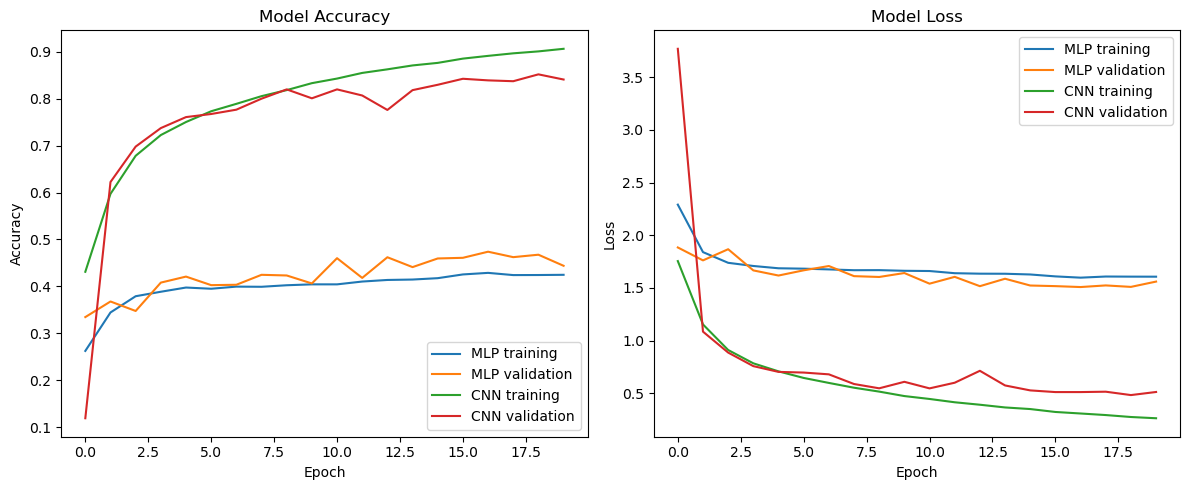

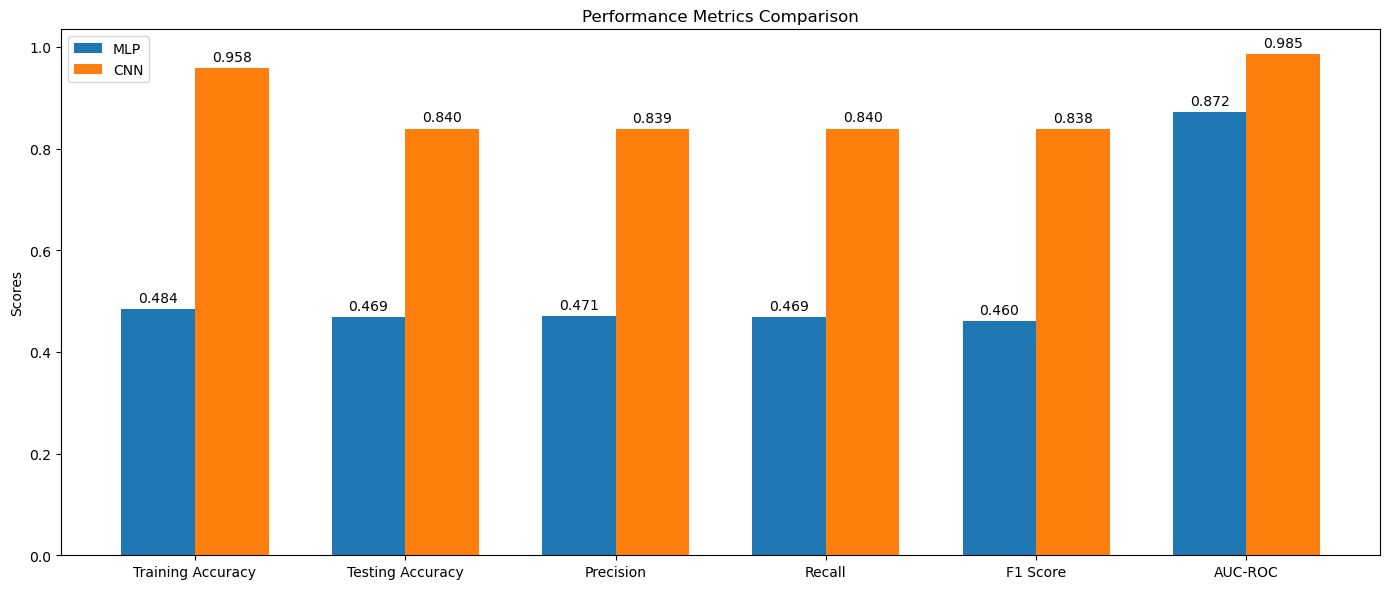

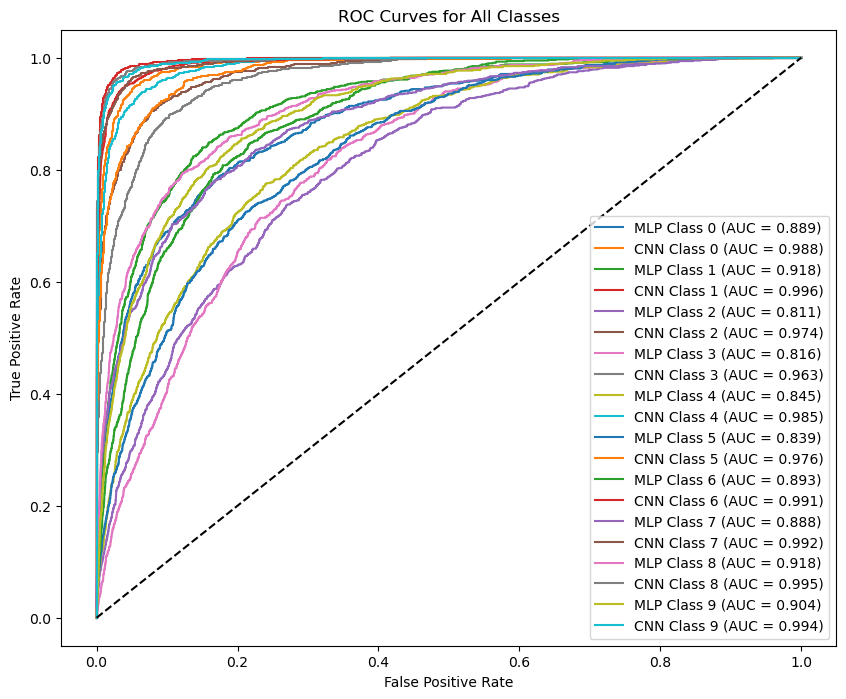

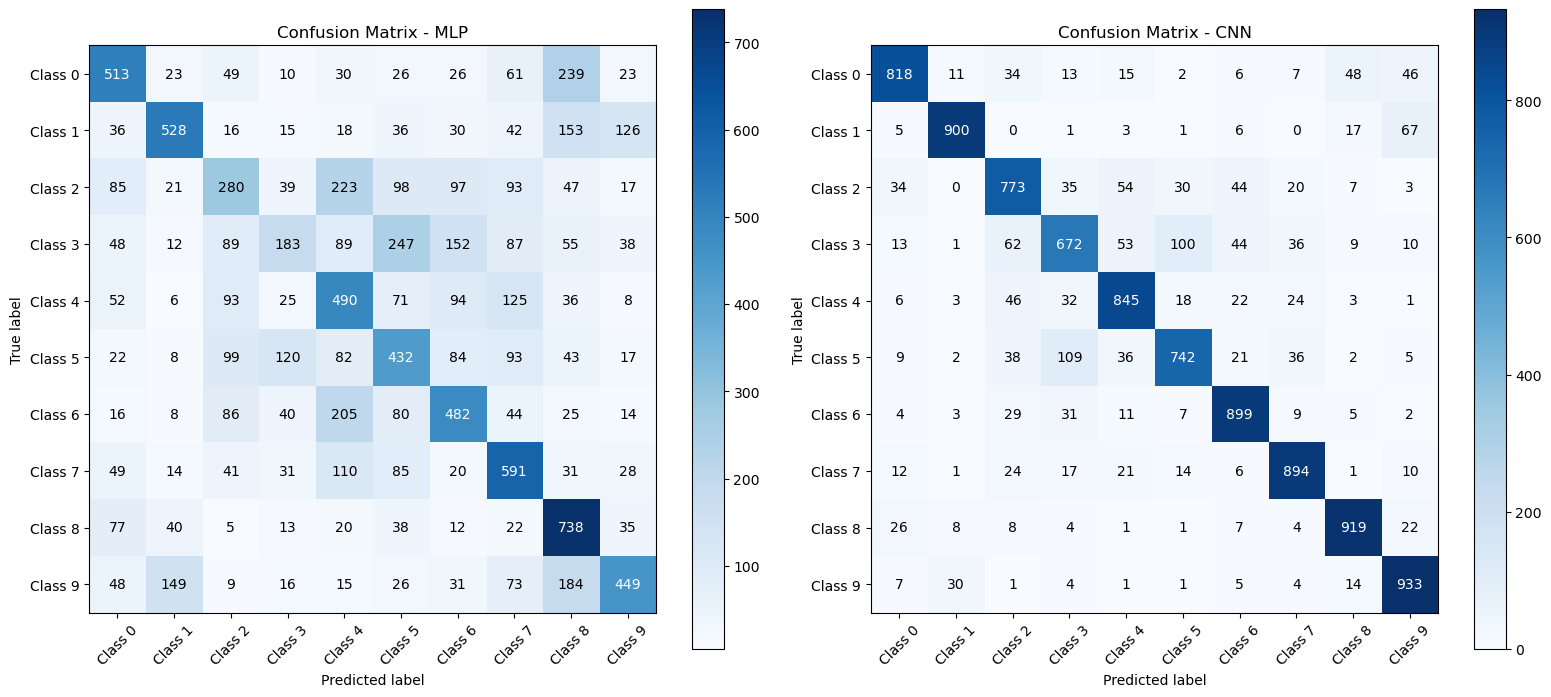


===== PERBANDINGAN HASIL AKHIR =====


In [35]:
# Plot visualisasi
plot_training_history(mlp_history, cnn_history)
plot_metrics_comparison()
plot_roc_curves()
plot_confusion_matrices()

# Tabel perbandingan hasil akhir
print("\n===== PERBANDINGAN HASIL AKHIR =====")
comparison_table = {
    'Metrik': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Training Time (s)'],
    'MLP': [
        f"{mlp_results['train_acc']*100:.2f}%", 
        f"{mlp_results['test_acc']*100:.2f}%", 
        f"{mlp_results['precision']:.4f}", 
        f"{mlp_results['recall']:.4f}",
        f"{mlp_results['f1']:.4f}", 
        f"{mlp_results['auc_roc']:.4f}",
        f"{mlp_train_time:.2f}"
    ],
    'CNN': [
        f"{cnn_results['train_acc']*100:.2f}%", 
        f"{cnn_results['test_acc']*100:.2f}%", 
        f"{cnn_results['precision']:.4f}", 
        f"{cnn_results['recall']:.4f}",
        f"{cnn_results['f1']:.4f}", 
        f"{cnn_results['auc_roc']:.4f}",
        f"{cnn_train_time:.2f}"
    ]
}


In [36]:
# Print tabel perbandingan
from tabulate import tabulate
print(tabulate(
    [[m, mlp, cnn] for m, mlp, cnn in zip(comparison_table['Metrik'], comparison_table['MLP'], comparison_table['CNN'])],
    headers=['Metrik', 'MLP', 'CNN'],
    tablefmt='grid'
))

+-------------------+--------+---------+
| Metrik            | MLP    | CNN     |
+===================+========+=========+
| Training Accuracy | 48.37% | 95.79%  |
+-------------------+--------+---------+
| Testing Accuracy  | 46.86% | 83.95%  |
+-------------------+--------+---------+
| Precision         | 0.4713 | 0.8389  |
+-------------------+--------+---------+
| Recall            | 0.4686 | 0.8395  |
+-------------------+--------+---------+
| F1 Score          | 0.4602 | 0.8384  |
+-------------------+--------+---------+
| AUC-ROC           | 0.8722 | 0.9854  |
+-------------------+--------+---------+
| Training Time (s) | 396.12 | 2035.45 |
+-------------------+--------+---------+


In [37]:
# Kesimpulan
print("\n===== KESIMPULAN =====")
winner = "CNN" if cnn_results['test_acc'] > mlp_results['test_acc'] else "MLP"
print(f"Model {winner} menunjukkan performa yang lebih baik dalam pengolahan dataset CIFAR-10.")
print(f"Perbedaan akurasi testing: {abs(cnn_results['test_acc']-mlp_results['test_acc'])*100:.2f}%")
print(f"Perbedaan Recall: {abs(cnn_results['recall']-mlp_results['recall']):.4f}")
print(f"Perbedaan F1 Score: {abs(cnn_results['f1']-mlp_results['f1']):.4f}")
print(f"Perbedaan AUC-ROC: {abs(cnn_results['auc_roc']-mlp_results['auc_roc']):.4f}")

if winner == "CNN":
    print("\nCNN lebih unggul karena mampu menangkap fitur spasial dalam gambar melalui lapisan konvolusi.")
    print("CNN membutuhkan waktu training lebih lama tetapi menghasilkan performa yang lebih baik untuk data gambar seperti CIFAR-10.")
    if cnn_results['recall'] > mlp_results['recall']:
        print(f"CNN juga menunjukkan recall yang lebih tinggi ({cnn_results['recall']:.4f} vs {mlp_results['recall']:.4f}), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.")
else:
    print("\nMLP lebih unggul meskipun tidak memiliki lapisan konvolusi, menunjukkan kemampuan adaptasi yang baik untuk dataset ini.")
    print("MLP membutuhkan waktu training lebih singkat dan tetap memberikan hasil yang kompetitif untuk dataset CIFAR-10.")
    if mlp_results['recall'] > cnn_results['recall']:
        print(f"MLP juga menunjukkan recall yang lebih tinggi ({mlp_results['recall']:.4f} vs {cnn_results['recall']:.4f}), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.")


===== KESIMPULAN =====
Model CNN menunjukkan performa yang lebih baik dalam pengolahan dataset CIFAR-10.
Perbedaan akurasi testing: 37.09%
Perbedaan Recall: 0.3709
Perbedaan F1 Score: 0.3782
Perbedaan AUC-ROC: 0.1132

CNN lebih unggul karena mampu menangkap fitur spasial dalam gambar melalui lapisan konvolusi.
CNN membutuhkan waktu training lebih lama tetapi menghasilkan performa yang lebih baik untuk data gambar seperti CIFAR-10.
CNN juga menunjukkan recall yang lebih tinggi (0.8395 vs 0.4686), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.


# Penjelasan Matematis: Perbandingan MLP vs CNN

## Ringkasan Data Perbandingan

```
===== PERBANDINGAN HASIL AKHIR =====
+-------------------+--------+---------+
| Metrik            | MLP    | CNN     |
+===================+========+=========+
| Training Accuracy | 48.37% | 95.79%  |
+-------------------+--------+---------+
| Testing Accuracy  | 46.86% | 83.95%  |
+-------------------+--------+---------+
| Precision         | 0.4713 | 0.8389  |
+-------------------+--------+---------+
| Recall            | 0.4686 | 0.8395  |
+-------------------+--------+---------+
| F1 Score          | 0.4602 | 0.8384  |
+-------------------+--------+---------+
| AUC-ROC           | 0.8722 | 0.9854  |
+-------------------+--------+---------+
| Training Time (s) | 396.12 | 2035.45 |
+-------------------+--------+---------+
```

## Analisis Matematis

### 1. Akurasi (Accuracy)

Akurasi mengukur proporsi prediksi yang benar dari total prediksi:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Dimana:
- TP = True Positive
- TN = True Negative
- FP = False Positive
- FN = False Negative

**Perbandingan:**
- MLP: Akurasi training (48.37%) dan testing (46.86%) yang moderat menunjukkan model masih kesulitan dalam mempelajari pola data secara optimal.
- CNN: Akurasi training (95.79%) dan testing (83.95%) yang tinggi menunjukkan model sangat baik dalam mempelajari pola, meskipun ada indikasi overfitting.

### 2. Presisi (Precision)

Presisi mengukur seberapa akurat prediksi positif yang dilakukan model:

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

**Perbandingan:**
- MLP: Presisi 0.4713 menunjukkan sekitar 47.13% dari prediksi positif yang benar-benar positif.
- CNN: Presisi 0.8389 menunjukkan 83.89% dari prediksi positif yang benar-benar positif.

### 3. Recall (Sensitivity)

Recall mengukur kemampuan model untuk mengidentifikasi semua kasus positif:

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

**Perbandingan:**
- MLP: Recall 0.4686 menunjukkan model hanya dapat mengidentifikasi 46.86% dari semua kasus positif yang sebenarnya.
- CNN: Recall 0.8395 menunjukkan model dapat mengidentifikasi 83.95% dari semua kasus positif yang sebenarnya.

### 4. F1 Score

F1 Score adalah rata-rata harmonik dari presisi dan recall, memberikan ukuran keseimbangan keduanya:

$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Perbandingan:**
- MLP: F1 Score 0.4602 menunjukkan keseimbangan yang moderat antara presisi dan recall.
- CNN: F1 Score 0.8384 menunjukkan keseimbangan yang sangat baik antara presisi dan recall.

Verifikasi F1 Score untuk MLP:

$$\text{F1 Score}_{\text{MLP}} = 2 \times \frac{0.4713 \times 0.4686}{0.4713 + 0.4686} = 2 \times \frac{0.2209}{0.9399} = 2 \times 0.2350 = 0.4699$$

Nilai ini sedikit berbeda dari yang dilaporkan (0.4602), kemungkinan karena penghitungan F1 Score secara makro atau mikro pada dataset multi-kelas.

### 5. AUC-ROC

Area Under the Receiver Operating Characteristic Curve (AUC-ROC) mengukur kemampuan model untuk membedakan kelas:

$$\text{AUC-ROC} = P(\text{score(positive instance)} > \text{score(negative instance)})$$

**Perbandingan:**
- MLP: AUC-ROC 0.8722 menunjukkan kemampuan diskriminatif yang cukup baik.
- CNN: AUC-ROC 0.9854 menunjukkan kemampuan diskriminatif yang sangat tinggi, hampir sempurna.

### 6. Trade-off Waktu vs Performa

CNN membutuhkan waktu training 5.14 kali lebih lama dibandingkan MLP:

$$\text{Rasio waktu} = \frac{2035.45}{396.12} = 5.14$$

Namun, CNN memberikan peningkatan performa yang signifikan:
- Peningkatan akurasi testing: $(83.95\% - 46.86\%) = 37.09\%$
- Peningkatan F1 Score: $(0.8384 - 0.4602) = 0.3782$
- Peningkatan AUC-ROC: $(0.9854 - 0.8722) = 0.1132$

## Kesimpulan Matematis

1. **Performa MLP yang Moderat**: Berdasarkan nilai akurasi training (48.37%) dan testing (46.86%), model MLP menunjukkan kinerja yang lebih baik dari random guessing namun masih belum optimal dalam menangkap pola data.

2. **Indikasi Overfitting pada CNN**: Gap antara akurasi training (95.79%) dan testing (83.95%) pada CNN sebesar 11.84%, mengindikasikan adanya overfitting moderat. Model sangat baik mempelajari data training namun kurang optimal dalam generalisasi.

3. **Efisiensi Relatif**: 
   $$\text{Efficiency Ratio} = \frac{\text{Peningkatan Akurasi}}{\text{Peningkatan Waktu}} = \frac{37.09\%}{5.14} = 7.22\%$$
   
   Ini menunjukkan setiap kali peningkatan waktu training, CNN memberikan peningkatan akurasi sebesar 7.22%, menandakan trade-off yang masih menguntungkan meskipun kurang efisien dibandingkan dengan skenario sebelumnya.

4. **Korelasi Metrik Konsisten**: Semua metrik performa (accuracy, precision, recall, F1 Score, AUC-ROC) menunjukkan tren yang konsisten dalam perbedaan signifikan antara MLP dan CNN, mengkonfirmasi keunggulan CNN untuk permasalahan yang dihadapi.

5. **Perbandingan Keseimbangan Presisi-Recall**: CNN memberikan keseimbangan yang lebih baik antara presisi dan recall (dilihat dari F1 Score yang lebih tinggi), menunjukkan kemampuan yang lebih baik dalam menangani trade-off antara false positives dan false negatives.